## Imports

In [1]:
%matplotlib inline

import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torchvision.transforms as transforms
import gradio as gr
import torch.nn.functional as F

from torchvision import datasets
from PIL import Image, ImageOps


c:\Users\damic\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## MNIST data set

Carichiamo in memoria il dataset MNIST. La prima volta potrebbe essere necessario scaricare i dati.  
Poi visualizziamo: stampiamo le prime 20 immagini con la loro classe associata.

In [2]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 32

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# choose the training and test datasets
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False,
                                  download=True, transform=transform)

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

100%|██████████| 9.91M/9.91M [00:00<00:00, 10.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 253kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 2.98MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.08MB/s]


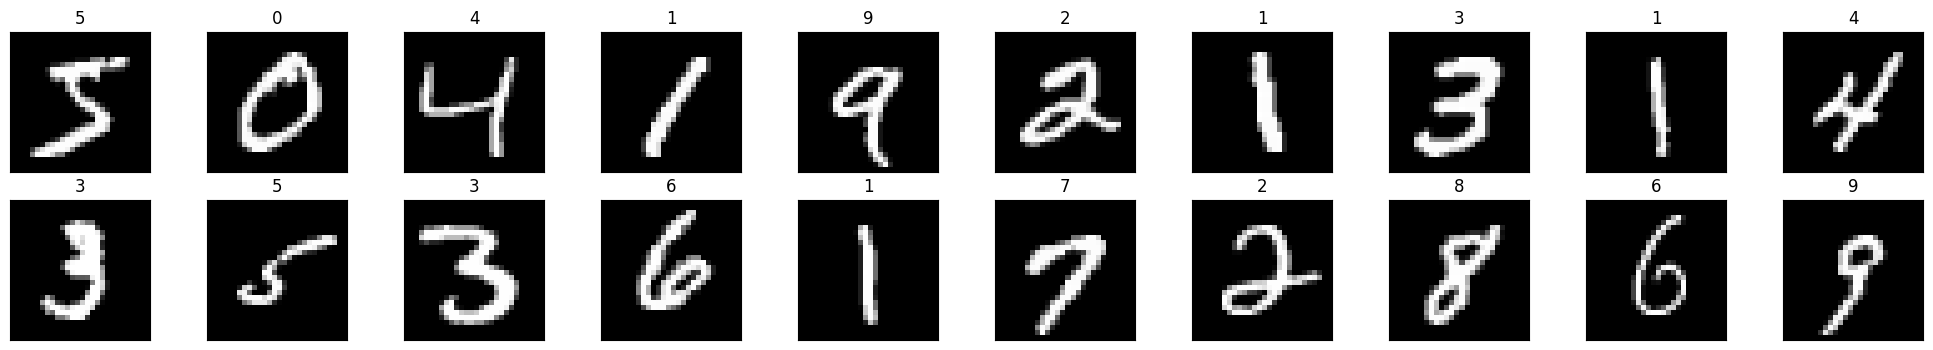

In [3]:
%matplotlib inline

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

 0  1  2  3  4  5  6  7  8  9  
[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]

----------------------------------------------------------
## Multi-layer perceptron (MLP) network

### Activation functions

Stampiamo alcune funzioni di attivazione più utilizzate nelle reti neurali.
* `'linear'` è semplicemente $y=x$, cioè il valore di ingresso corrisponde al valore di uscita
* `'relu'` vuol dire 'rectified linear unit', $y=\max(0,x)$, una semplice funzione non lineare che useremo nel MLP. Il vantaggio di questa funzione è che il nodo non si attiverà per valori negativi (*output = 0*)
* `'sigmoid'` e `'tanh'` funzioni non lineari già note. Permettono di modellare l'attivazione in maniera più complessa portando parecchia complessità computazionale nella rete neurale, durante il calcolo del gradiente.


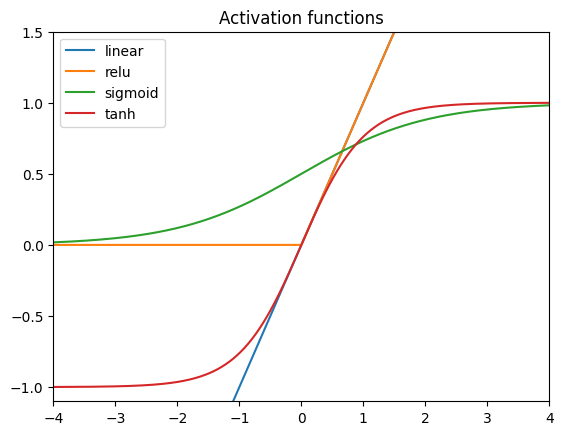

In [4]:
x = np.arange(-4,4,.01)
plt.figure()
plt.plot(x, x, label='linear')
plt.plot(x, np.maximum(x,0), label='relu')
plt.plot(x, 1/(1+np.exp(-x)), label='sigmoid')
plt.plot(x, np.tanh(x), label='tanh')
plt.axis([-4, 4, -1.1, 1.5])
plt.title('Activation functions')
plt.legend(loc='best');

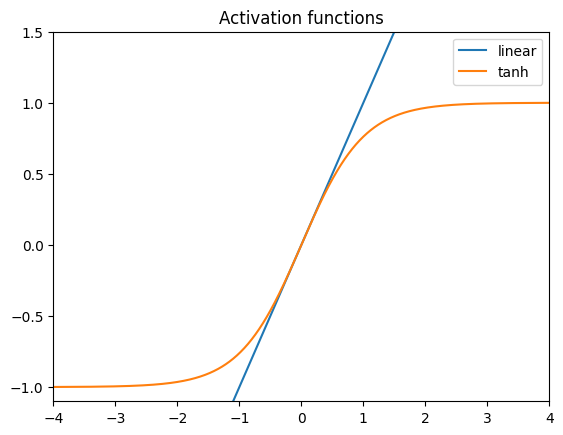

In [5]:
x = np.arange(-4,4,.01)
plt.figure()
plt.plot(x, x, label='linear')
plt.plot(x, np.tanh(x), label='tanh')
plt.axis([-4, 4, -1.1, 1.5])
plt.title('Activation functions')
plt.legend(loc='best');

### Initialization

Creiamo ora un modello di MLP più complesso:
* più strati intermedi
* funzione di attivazione **non** lineare
* strati con dropout

Il metodo `Dropout()` imposta una frazione di input (casuali) uguali a zero durante l'addestramento. E' un approccio per regolarizzare i dati e, a volte, permette di combattere l'overfitting.

In [6]:
import torch.nn as nn
import torch.nn.functional as F

## Define the NN architecture
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 20)
        # linear layer (n_hidden -> hidden_2)
        self.fc2 = nn.Linear(20, 20)
        # linear layer (n_hidden -> 10)
        self.fc3 = nn.Linear(20, 10)
        # dropout layer (p=0.2)
        # dropout prevents overfitting of data
        self.dropout = nn.Dropout(0.2)

        self.relu = F.relu

    def forward(self, x):
        # flatten image input
        x = x.view(-1, 28 * 28)

        # add hidden layer, with relu activation function
        x = self.fc3(self.dropout(self.relu(self.fc2(self.relu(self.fc1(x))))))

        # it's equivalent to:
        # first_layer_output = self.fc1(x)
        #
        # second_layer_input = self.relu(first_layer_outputs)
        # second_layer_output = self.fc2(second_layer_input)
        #
        # third_layer_input = self.relu(second_layer_outputs)
        # third_layer_input_with_dropout = self.dropout(third_layer_input)
        # third_layer_output = self.fc3(third_layer_input_with_dropout)
        #
        # return third_layer_output

        return x

# initialize the NN
model = MLP()
print(model)

MLP(
  (fc1): Linear(in_features=784, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


### Learning
*IMPORTANTE*: poiché il modello è cambiato (ora abbiamo `model2`), l'optimizer deve essere aggiornato con i parametri del nuovo modello.

In [7]:
# implement it in the network definition
criterion = nn.CrossEntropyLoss()

# redefine the optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [8]:
# number of epochs to train the model
n_epochs = 50  # suggest training between 20-50 epochs

model.train() # prep model for training

for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0

    ###################
    # train the model #
    ###################
    for data, target in train_loader:
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)

    # print training statistics
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader.dataset)

    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch+1,
        train_loss
        ))

Epoch: 1 	Training Loss: 1.517202
Epoch: 2 	Training Loss: 0.696247
Epoch: 3 	Training Loss: 0.555511
Epoch: 4 	Training Loss: 0.496027
Epoch: 5 	Training Loss: 0.457008
Epoch: 6 	Training Loss: 0.434561
Epoch: 7 	Training Loss: 0.404601
Epoch: 8 	Training Loss: 0.379880
Epoch: 9 	Training Loss: 0.363952
Epoch: 10 	Training Loss: 0.341400
Epoch: 11 	Training Loss: 0.329438
Epoch: 12 	Training Loss: 0.318422
Epoch: 13 	Training Loss: 0.308048
Epoch: 14 	Training Loss: 0.296995
Epoch: 15 	Training Loss: 0.292727
Epoch: 16 	Training Loss: 0.285429
Epoch: 17 	Training Loss: 0.276815
Epoch: 18 	Training Loss: 0.272581
Epoch: 19 	Training Loss: 0.263605
Epoch: 20 	Training Loss: 0.259786
Epoch: 21 	Training Loss: 0.255682
Epoch: 22 	Training Loss: 0.247811
Epoch: 23 	Training Loss: 0.244221
Epoch: 24 	Training Loss: 0.243427
Epoch: 25 	Training Loss: 0.235795
Epoch: 26 	Training Loss: 0.233654
Epoch: 27 	Training Loss: 0.228344
Epoch: 28 	Training Loss: 0.226689
Epoch: 29 	Training Loss: 0.2

### Inference

Testiamo il modello e calcoliamo l'Accuracy. Dovrebbe essere leggermente migliore rispetto a quello lineare.

In [9]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() # prep model for *evaluation*

for data, target in test_loader:
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(len(target.data)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.149824

Test Accuracy of     0: 98% (966/980)
Test Accuracy of     1: 98% (1119/1135)
Test Accuracy of     2: 95% (987/1032)
Test Accuracy of     3: 93% (946/1010)
Test Accuracy of     4: 94% (931/982)
Test Accuracy of     5: 95% (852/892)
Test Accuracy of     6: 95% (913/958)
Test Accuracy of     7: 94% (973/1028)
Test Accuracy of     8: 94% (919/974)
Test Accuracy of     9: 95% (959/1009)

Test Accuracy (Overall): 95% (9565/10000)


E di nuovo, vediamo le prime 20 cifre classificate dal modello.

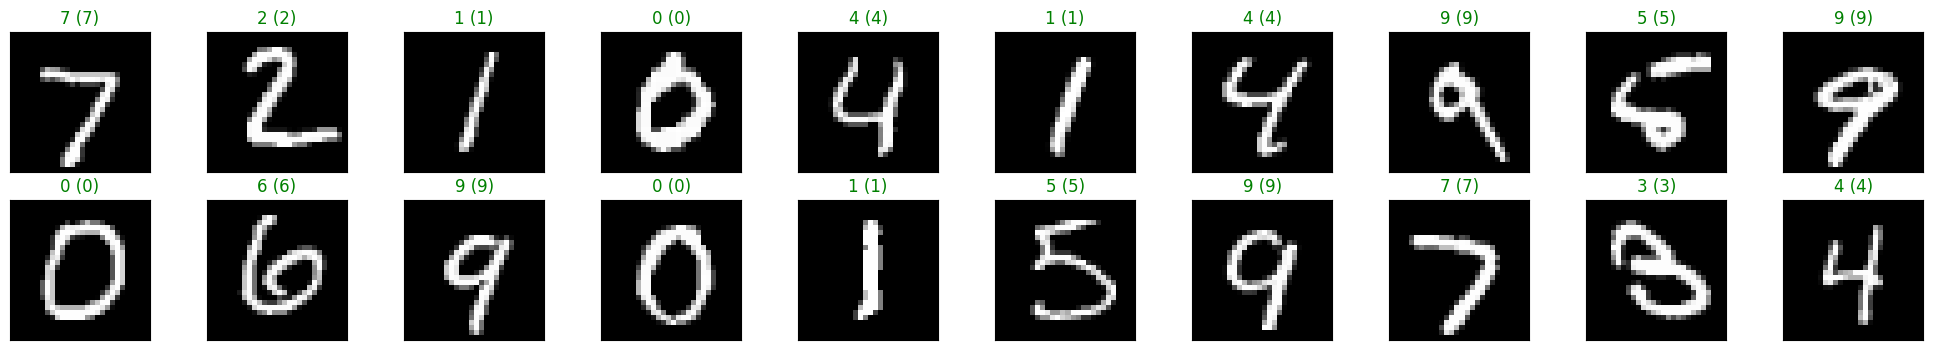

In [10]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))

In [11]:
# Salva i pesi del modello
torch.save(model.state_dict(), 'model_mnist_weights.pth')
print("Pesi salvati correttamente!")

Pesi salvati correttamente!


In [13]:
def predict_digit(input_data):
    try:
        # Caricamento e conversione in scala di grigi
        img = Image.open(path).convert('L')
        
        # Auto-inversione (se lo sfondo è chiaro, lo rende nero)
        if np.array(img).mean() > 127:
            img = ImageOps.invert(img)
            
        # Ritaglio e Centramento
        bbox = img.getbbox()
        if bbox:
            img = img.crop(bbox)
            w, h = img.size
            max_dim = max(w, h)
            canvas = Image.new('L', (int(max_dim*1.6), int(max_dim*1.6)), 0)
            canvas.paste(img, (int((max_dim*1.6 - w)//2), int((max_dim*1.6 - h)//2)))
            img = canvas
            
        # Ridimensionamento a 28x28 (Standard MNIST)
        img = img.resize((28, 28), Image.Resampling.LANCZOS)
        
        # Trasformazione in tensore
        img_array = np.array(img).astype('float32') / 255.0
        img_tensor = torch.from_numpy(img_array).view(1, 784)
        
        # Predizione
        with torch.no_grad():
            output = model(img_tensor)
            probs = F.softmax(output, dim=1)
            prob_max, pred = torch.max(probs, 1)
            
        print(f"--- RISULTATO ---")
        print(f"Percorso: {path}")
        print(f"Numero Predetto: {pred.item()}")
        print(f"Sicurezza: {prob_max.item():.2%}")
        
    except Exception as e:
        print(f"Errore nel caricamento dell'immagine: {e}")

predict_digit(percorso_immagine)

NameError: name 'percorso_immagine' is not defined